In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from simulation_configs import generateConfigurations
from simulation_modules import DisturbanceModule, ProcessModule, FaultModule, MeasurementModule, RegulatoryControlModule, SupervisoryControlModule, MaintenanceModule, MonitoringModule
import inspect
import pprint
import pandas as pd
import time as real_time

In [2]:
# Repeatable results
np.random.seed(100)

In [3]:
# Generate configurations
t, d, u, p, x, f, y, r, m, econ = generateConfigurations(maintenance_strategy=3)

In [4]:
# Monitoring parameters
pprint.pprint(m)

{'Xtrain': array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]]),
 'components': {'C': {'alarm': array([nan, nan, nan, ..., nan, nan, nan]),
                      'warning': array([nan, nan, nan, ..., nan, nan, nan])},
                'C0': {'alarm': array([nan, nan, nan, ..., nan, nan, nan]),
                       'warning': array([nan, nan, nan, ..., nan, nan, nan])},
                'F': {'alarm': array([nan, nan, nan, ..., nan, nan, nan]),
                      'warning': array([nan, nan, nan, ..., nan, nan, nan])},
                'F0': {'alarm': array([nan, nan, nan, ..., nan, nan, nan]),
                       'warning': array([nan, nan, nan, ..., nan, nan, nan])},
                'FW': {'alarm': array([nan, nan, nan, ..., nan, nan, nan]),
                       'warning': array([nan, nan

In [5]:
# Monitoring module
print(inspect.getsource(MonitoringModule))

def MonitoringModule(m, y, r, t):
    # Training of monitoring model happens after initial transient, 
    # and after specified training time
    # Training data collection occurs before training end time
    if m['training'] and t['tvector'][t['i']]<m['trainingEndTime']:
        m = collectTrainingData(m, y, t)

    # Training occurs once during the entire simulation
    elif m['training'] and t['tvector'][t['i']]>=m['trainingEndTime']:
        # Remove nans from training data
        # Find rows with any NaNs
        rows_with_nans = np.any(np.isnan(m['Xtrain']), axis=1)
        # Find rows without any NaNs
        rows_without_nans = ~rows_with_nans
        # Select rows that do not contain any NaNs
        m['Xtrain'] = m['Xtrain'][rows_without_nans]

        # Center and scale the data
        m['model']['mX'] = np.mean(m['Xtrain'], axis=0)
        m['model']['sX'] = np.std(m['Xtrain'], axis=0)
        m['Xtrain'] = (m['Xtrain'] - m['model']['mX'])/m['model']['sX']

        # Cal

In [6]:
# Generate disturbances
d_range = DisturbanceModule(d,t)

In [7]:
# Simulation
# Start timer for simulation duration
start_time = real_time.time()
# List of variables to save
results_list = ['Time (s)', 'V', 'xWv', 
                'L', 'F0m', 'FWm', 'Fm',
                'Cm',
                'Regime',
                'MonitoringActive',
                'T2stat', 'SPEstat']
# Preallocate numpy array to store results
results = np.full((t['N'], len(results_list)),np.nan)
# Start simulation
print('Simulation progress:')
while t['tvector'][t['i']] < t['tmax']:
    # Current disturbance
    d_now = {col: d_range[col][t['i']] for col in ['F0', 'C0']}

    # Supervisory control module
    r = SupervisoryControlModule(r, m, y, t)
    # Maintenance module
    if r['regime']=='Shut':
        r, f, t = MaintenanceModule(r, f, t) # t['i'] updated during maintenance
    # Regulatory control module
    u = RegulatoryControlModule(u, y, r)
    # Process module
    x = ProcessModule(p, u, d_now, x, f)
    # Fault module
    f = FaultModule(p, x, f, t)
    # Measurement module
    y = MeasurementModule(y, x, d_now, f)
    # Monitoring module
    m = MonitoringModule(m, y, r, t)
    # Update results
    results[t['i'], :] = [
        t['tvector'][t['i']], 
        x['V'], 
        x['xWv'], 
        x['L'],
        y['F0']['value'], 
        y['FW']['value'], 
        y['F']['value'],
        y['C']['value'],
        r['regimeNumeric'],
        m['monitoringActive'],
        m['statistic']['T2'][t['i']][0],
        m['statistic']['SPE'][t['i']][0]
        ]
    # Display progress in percent time
    if t['i'] % 100000 == 0:
        print(f'{t["tvector"][t["i"]]/t["tmax"]*100:.2f}%')
    # Update time index
    t['i'] += 1

# End timer for simulation duration
end_time = real_time.time()
# Print simulation duration
print(f'Done! Simulation duration: {end_time-start_time:.1f} seconds.')

Simulation progress:
0.00%
7.23%
14.47%
21.70%
28.94%
36.17%
43.40%
50.64%
57.87%
65.10%
72.34%
79.57%
86.81%
94.04%
Done! Simulation duration: 47.6 seconds.


In [10]:
# Convert results (numpy array) to DataFrame
df = pd.DataFrame(results, columns=results_list)
df.set_index('Time (s)', inplace=True)

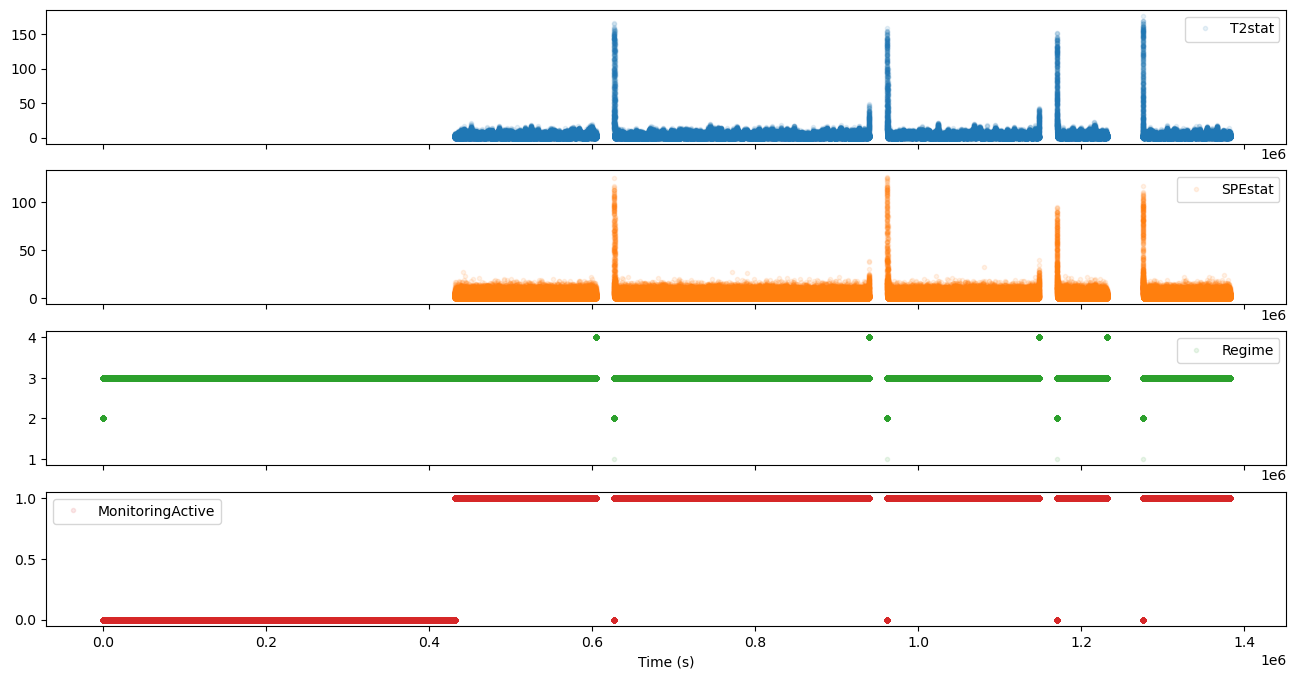

In [11]:
# Monitoring plots: Statistics, activity and regimes
startInd = 0
endInd = t['N']
plot_list = ['T2stat', 'SPEstat', 'Regime', 'MonitoringActive']
ax = df[plot_list].iloc[startInd:endInd].plot(subplots=True, marker='.', ls='none', alpha=0.1, figsize=(16,8))

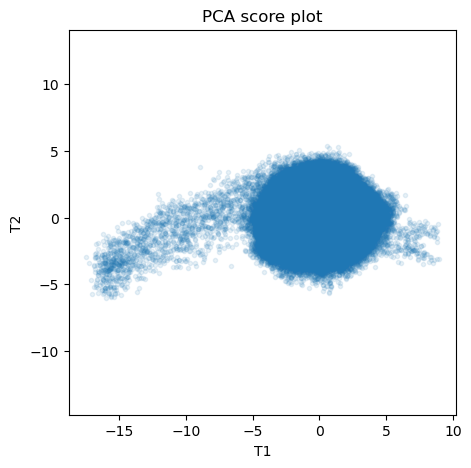

In [12]:
# Monitoring plots: Score plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(m['statistic']['T'][:,0], m['statistic']['T'][:,1], marker='.', ls='none', alpha=0.1)
ax.set_xlabel('T1')
ax.set_ylabel('T2')
ax.set_title('PCA score plot')
ax.axis('equal')
plt.show()